# TBX1 Cohort Analysis Report

TBX1 or T box 1 is a transcription factor crucial for the prenatal establishment of the thymus [Lindsay et al. (2001)](https://pubmed.ncbi.nlm.nih.gov/11242049/). In humans, monoallelic loss-of-function mutations in TBX1 have been associated with the development of velo-cardio-facial, or DiGeorge, syndrome [Merscher et al. (2001)](https://pubmed.ncbi.nlm.nih.gov/11239417/). Interestingly, missense mutations leading to increased TBX1 activity also result in phenotypically similar syndrome [Zweier et al. (2007)](https://pubmed.ncbi.nlm.nih.gov/17273972/) - characterized by velopharyngeal insufficiency, hypoplastic thymus, immunodeficiency, hypoparathyroidism, craniofacial dysmorphia, hearing impairment and cardiac defect [Papangeli et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/23799583/). All mutations in TBX1 seem highly variably penetrant, with some patients presenting without signs of immunodeficiency, while others present with life-threatening congenital athymia requiring corrective treatment with a thymic transplant [Kreins et al. (2021)](https://pubmed.ncbi.nlm.nih.gov/33815417/).

In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")


Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### TBX1
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TBX1.

In [10]:
gene_symbol = 'TBX1'
mane_tx_id = 'NM_080647.1' #  was 'NM_001379200.1'
mane_protein_id = 'NP_542378.1' ## was'NP_001366129.1'


In [12]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.21' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')


cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Loaded 26 phenopackets
Individuals Processed: 100%|██████████| 26/26 [00:00<00:00, 924.38individuals/s]
Loaded 26 individuals
Validated under permissive policy
No errors or warnings were found


## Cohort Overview


In [13]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort)

HPO Term,ID,Seen in n individuals
Abnormal facial shape,HP:0001999,20
Hypoparathyroidism,HP:0000829,14
Low-set ears,HP:0000369,13
Velopharyngeal insufficiency,HP:0000220,13
Hypertelorism,HP:0000316,12
Micrognathia,HP:0000347,11
Blepharophimosis,HP:0000581,9
Global developmental delay,HP:0001263,8
Sensorineural hearing impairment,HP:0000407,5
Narrow nose,HP:0000460,5


## 4. Visualizing the TBX1 Protein Structure

We visualize the TBX1 protein structure and save the image.


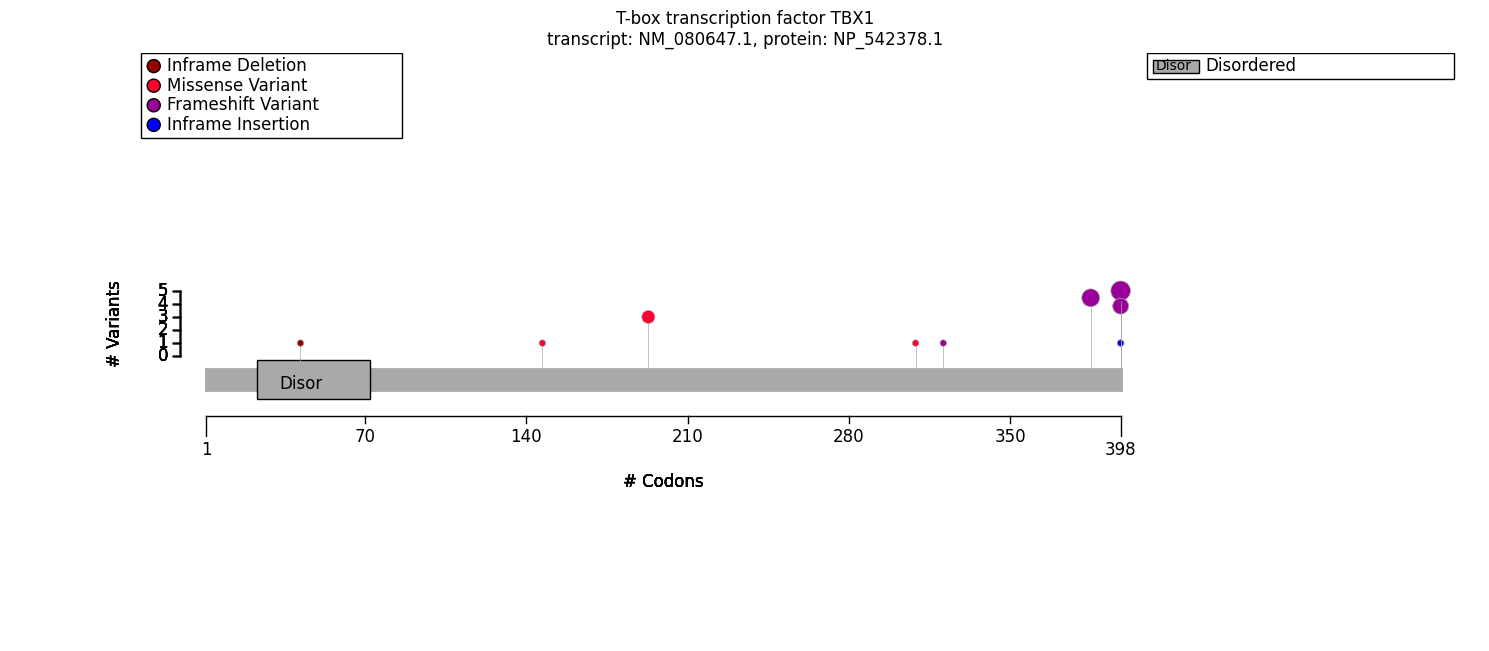

In [14]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


tbx1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tbx1_fig.tight_layout()

In [15]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Abnormal facial shape,HP:0001999,20
Hypoparathyroidism,HP:0000829,14
Low-set ears,HP:0000369,13
Velopharyngeal insufficiency,HP:0000220,13
Hypertelorism,HP:0000316,12
Micrognathia,HP:0000347,11
Blepharophimosis,HP:0000581,9
Global developmental delay,HP:0001263,8
Sensorineural hearing impairment,HP:0000407,5
Narrow nose,HP:0000460,5


## Genotype-Phenotype Correlation (GPC) Analysis

In [16]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [18]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate.genotype import monoallelic_predicate, VariantPredicates

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id),
UTR5 = VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, mane_tx_id)

missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,13
HMF03,Skipping term because of a child term with the same individual counts,11
HMF05,Skipping term because one genotype had zero observations,1
HMF08,Skipping general term,42
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,41


In [19]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                    Missense          Other  \
                                                   Count Percent  Count   
Blepharophimosis [HP:0000581]                        4/4    100%   5/14   
Hypoparathyroidism [HP:0000829]                      1/4     25%  13/17   
Micrognathia [HP:0000347]                            4/4    100%   7/14   
Low-set ears [HP:0000369]                            4/4    100%   9/14   
Sensorineural hearing impairment [HP:0000407]        1/1    100%   4/13   
Abnormal facial shape [HP:0001999]                   4/4    100%  16/21   
Hypertelorism [HP:0000316]                           2/2    100%  10/13   
Abnormal location of ears [HP:0000357]               4/4    100%    9/9   
Aplasia/Hypoplasia of the mandible [HP:0009118]      4/4    100%    7/7   
Abnormal axial skeleton morphology [HP:0009121]      4/4    100%    7/7   
Velopharyngeal insufficiency [HP:0000220]            2/4     50%  11/20   
Abnormal soft palate morphology [HP:0100736]         2/2    100%  11/11   

Allele group                                                                \
                                                Percent Corrected p values   
Blepharophimosis [HP:0000581]                       36%           0.477124   
Hypoparathyroidism [HP:0000829]                     76%           0.477124   
Micrognathia [HP:0000347]                           50%           0.477124   
Low-set ears [HP:0000369]                           64%           0.833333   
Sensorineural hearing impairment [HP:0000407]       31%           0.857143   
Abnormal facial shape [HP:0001999]                  76%           1.000000   
Hypertelorism [HP:0000316]                          77%           1.000000   
Abnormal location of ears [HP:0000357]             100%           1.000000   
Aplasia/Hypoplasia of the mandible [HP:0009118]    100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]    100%           1.000000   
Velopharyngeal insufficiency [HP:0000220]           55%           1.000000   
Abnormal soft palate morphology [HP:0100736]       100%           1.000000   

Allele group                                               
                                                 p values  
Blepharophimosis [HP:0000581]                    0.082353  
Hypoparathyroidism [HP:0000829]                  0.087719  
Micrognathia [HP:0000347]                        0.119281  
Low-set ears [HP:0000369]                        0.277778  
Sensorineural hearing impairment [HP:0000407]    0.357143  
Abnormal facial shape [HP:0001999]               0.549407  
Hypertelorism [HP:0000316]                       1.000000  
Abnormal location of ears [HP:0000357]           1.000000  
Aplasia/Hypoplasia of the mandible [HP:0009118]  1.000000  
Abnormal axial skeleton morphology [HP:0009121]  1.000000  
Velopharyngeal insufficiency [HP:0000220]        1.000000  
Abnormal soft palate morphology [HP:0100736]     1.000000

In [21]:
# 22_19766631_19766632_TA_T  


Tyr418PhefsTer42 = VariantPredicates.variant_key("22_19766631_19766632_TA_T") #  c.1253del	p.Tyr418PhefsTer42

Tyr418PhefsTer42_predicate = monoallelic_predicate(
    a_predicate=Tyr418PhefsTer42,
    b_predicate=~Tyr418PhefsTer42,
    a_label="Tyr418PhefsTer42",
    b_label="Other"
)

Tyr418PhefsTer42_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=Tyr418PhefsTer42_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=Tyr418PhefsTer42_result)


Allele group                                    Tyr418PhefsTer42          \
                                                           Count Percent   
Global developmental delay [HP:0001263]                      5/5    100%   
Narrow nose [HP:0000460]                                     5/5    100%   
Blepharophimosis [HP:0000581]                                5/5    100%   
Velopharyngeal insufficiency [HP:0000220]                    5/5    100%   
Micrognathia [HP:0000347]                                    5/5    100%   
Low-set ears [HP:0000369]                                    5/5    100%   
Hypertelorism [HP:0000316]                                   5/5    100%   
Abnormal facial shape [HP:0001999]                           5/5    100%   
Sensorineural hearing impairment [HP:0000407]                1/5     20%   
Abnormal location of ears [HP:0000357]                       5/5    100%   
Aplasia/Hypoplasia of the mandible [HP:0009118]              5/5    100%   
Abnormal axial skeleton morphology [HP:0009121]              5/5    100%   
Hypoparathyroidism [HP:0000829]                              3/5     60%   
Abnormal soft palate morphology [HP:0100736]                 5/5    100%   

Allele group                                     Other          \
                                                 Count Percent   
Global developmental delay [HP:0001263]           3/20     15%   
Narrow nose [HP:0000460]                           0/6      0%   
Blepharophimosis [HP:0000581]                     4/13     31%   
Velopharyngeal insufficiency [HP:0000220]         8/19     42%   
Micrognathia [HP:0000347]                         6/13     46%   
Low-set ears [HP:0000369]                         8/13     62%   
Hypertelorism [HP:0000316]                        7/10     70%   
Abnormal facial shape [HP:0001999]               15/20     75%   
Sensorineural hearing impairment [HP:0000407]      4/9     44%   
Abnormal location of ears [HP:0000357]             8/8    100%   
Aplasia/Hypoplasia of the mandible [HP:0009118]    6/6    100%   
Abnormal axial skeleton morphology [HP:0009121]    6/6    100%   
Hypoparathyroidism [HP:0000829]                  11/16     69%   
Abnormal soft palate morphology [HP:0100736]       8/8    100%   

Allele group                                                                  
                                                Corrected p values  p values  
Global developmental delay [HP:0001263]                   0.014756  0.001054  
Narrow nose [HP:0000460]                                  0.015152  0.002165  
Blepharophimosis [HP:0000581]                             0.137255  0.029412  
Velopharyngeal insufficiency [HP:0000220]                 0.144022  0.041149  
Micrognathia [HP:0000347]                                 0.283660  0.101307  
Low-set ears [HP:0000369]                                 0.580882  0.248950  
Hypertelorism [HP:0000316]                                0.902875  0.505495  
Abnormal facial shape [HP:0001999]                        0.902875  0.544043  
Sensorineural hearing impairment [HP:0000407]             0.902875  0.580420  
Abnormal location of ears [HP:0000357]                    1.000000  1.000000  
Aplasia/Hypoplasia of the mandible [HP:0009118]           1.000000  1.000000  
Abnormal axial skeleton morphology [HP:0009121]           1.000000  1.000000  
Hypoparathyroidism [HP:0000829]                           1.000000  1.000000  
Abnormal soft palate morphology [HP:0100736]              1.000000  1.000000

 # 5 prime UTR variant vs all others

In [ ]:
from gpsea.model import VariantEffect





gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
    ),
    group_names=("MISSENSE", "FRAMESHIFT", '5_prime')
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
) 

)

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ## Manually curated features

In [34]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Hypertelorism [HP:0000316]                              2/5     40%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   

Genotype group                                     FRAMESHIFT         5_prime  \
                                                        Count Percent   Count   
Hypertelorism [HP:0000316]                              11/15     73%     0/3   
Abnormal facial shape [HP:0001999]                      19/20     95%     2/3   
Hypoparathyroidism [HP:0000829]                         11/17     65%     0/3   
Low-set ears [HP:0000369]                               12/16     75%     1/3   
Blepharophimosis [HP:0000581]                            6/16     38%     0/3   
Narrow nose [HP:0000460]                                 5/13     38%     0/3   
Bulbous nose [HP:0000414]                                4/13     31%     0/3   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%     0/0   
Abnormal pinna morphology [HP:0000377]                  12/12    100%     1/1   
Micrognathia [HP:0000347]                                7/15     47%     1/3   
Abnormality of the cardiovascular system [HP:00...        8/8    100%     2/2   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%     0/0   

Genotype group                                                                 \
                                                   Percent Corrected p values   
Hypertelorism [HP:0000316]                              0%           0.343171   
Abnormal facial shape [HP:0001999]                     67%           0.343171   
Hypoparathyroidism [HP:0000829]                         0%           0.343171   
Low-set ears [HP:0000369]                              33%           0.819401   
Blepharophimosis [HP:0000581]                           0%           0.819401   
Narrow nose [HP:0000460]                                0%           0.819401   
Bulbous nose [HP:0000414]                               0%           0.955330   
Velopharyngeal insufficiency [HP:0000220]               0%           0.997826   
Abnormal pinna morphology [HP:0000377]                100%           1.000000   
Micrognathia [HP:0000347]                              33%           1.000000   
Abnormality of the cardiovascular system [HP:00...    100%           1.000000   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%           1.000000   

Genotype group                                                
                                                    p values  
Hypertelorism [HP:0000316]                          0.029658  
Abnormal facial shape [HP:0001999]                  0.071021  
Hypoparathyroidism [HP:0000829]                     0.085793  
Low-set ears [HP:0000369]                           0.360200  
Blepharophimosis [HP:0000581]                       0.362968  
Narrow nose [HP:0000460]                            0.409701  
Bulbous nose [HP:0000414]                           0.557276  
Velopharyngeal insufficiency [HP:0000220]           0.665217  
Abnormal pinna morphology [HP:0000377]              1.000000  
Micrognathia [HP:0000347]                 

In [35]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                ),
    group_names=("MISSENSE", "FRAMESHIFT")
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
) 
)


from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ## Manually curated features

In [37]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Hypertelorism [HP:0000316]                              2/5     40%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   

Genotype group                                     FRAMESHIFT          \
                                                        Count Percent   
Abnormal facial shape [HP:0001999]                      19/20     95%   
Hypertelorism [HP:0000316]                              11/15     73%   
Hypoparathyroidism [HP:0000829]                         11/17     65%   
Narrow nose [HP:0000460]                                 5/13     38%   
Bulbous nose [HP:0000414]                                4/13     31%   
Low-set ears [HP:0000369]                               12/16     75%   
Blepharophimosis [HP:0000581]                            6/16     38%   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%   
Abnormal pinna morphology [HP:0000377]                  12/12    100%   
Micrognathia [HP:0000347]                                7/15     47%   
Abnormality of the cardiovascular system [HP:00...        8/8    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%   

Genotype group                                                         \
                                                   Corrected p values   
Abnormal facial shape [HP:0001999]                           0.912467   
Hypertelorism [HP:0000316]                                   0.997826   
Hypoparathyroidism [HP:0000829]                              0.997826   
Narrow nose [HP:0000460]                                     0.997826   
Bulbous nose [HP:0000414]                                    0.997826   
Low-set ears [HP:0000369]                                    0.997826   
Blepharophimosis [HP:0000581]                                0.997826   
Velopharyngeal insufficiency [HP:0000220]                    0.997826   
Abnormal pinna morphology [HP:0000377]                       1.000000   
Micrognathia [HP:0000347]                                    1.000000   
Abnormality of the cardiovascular system [HP:00...           1.000000   
Aplasia/Hypoplasia of the thymus [HP:0010515]                1.000000   

Genotype group                                                
                                                    p values  
Abnormal facial shape [HP:0001999]                  0.076039  
Hypertelorism [HP:0000316]                          0.289796  
Hypoparathyroidism [HP:0000829]                     0.341288  
Narrow nose [HP:0000460]                            0.508929  
Bulbous nose [HP:0000414]                           0.528571  
Low-set ears [HP:0000369]                           0.625840  
Blepharophimosis [HP:0000581]                       0.650020  
Velopharyngeal insufficiency [HP:0000220]           0.665217  
Abnormal pinna morphology [HP:0000377]              1.000000  
Micrognathia [HP:0000347]                           1.000000  
Abnormality of the cardiovascular system [HP:00...  1.000000  
Aplasia/Hypoplasia of the thymus [HP:0010515]       1.000000

In [38]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('22_19766631_19766632_TA_T'), 
                VariantPredicates.variant_key('22_19760805_19760805_C_T'),
                VariantPredicates.variant_key('22_19766537_19766538_CG_T'),
    ),
    group_names=("22_19766631_19766632_TA_T", "22_19760805_19760805_C_T", '22_19766537_19766538_CG_T')
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pecified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
)
) 


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df.to_csv('tbx1_variant.csv')


## Manually curated top 3 variants

In [40]:
display(summary_df)

Genotype group                                     22_19766631_19766632_TA_T  \
                                                                       Count   
Blepharophimosis [HP:0000581]                                            5/5   
Narrow nose [HP:0000460]                                                 5/5   
Velopharyngeal insufficiency [HP:0000220]                                5/5   
Hypertelorism [HP:0000316]                                               5/5   
Bulbous nose [HP:0000414]                                                0/5   
Hypoparathyroidism [HP:0000829]                                          3/5   
Micrognathia [HP:0000347]                                                5/5   
Low-set ears [HP:0000369]                                                5/5   
Abnormal facial shape [HP:0001999]                                       5/5   
Abnormal pinna morphology [HP:0000377]                                   5/5   
Abnormality of the cardiovascular system [HP:00...                       0/0   
Aplasia/Hypoplasia of the thymus [HP:0010515]                            0/1   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                         100%   
Narrow nose [HP:0000460]                              100%   
Velopharyngeal insufficiency [HP:0000220]             100%   
Hypertelorism [HP:0000316]                            100%   
Bulbous nose [HP:0000414]                               0%   
Hypoparathyroidism [HP:0000829]                        60%   
Micrognathia [HP:0000347]                             100%   
Low-set ears [HP:0000369]                             100%   
Abnormal facial shape [HP:0001999]                    100%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...      0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   

Genotype group                                     22_19760805_19760805_C_T  \
                                                                      Count   
Blepharophimosis [HP:0000581]                                           0/3   
Narrow nose [HP:0000460]                                                0/3   
Velopharyngeal insufficiency [HP:0000220]                               0/0   
Hypertelorism [HP:0000316]                                              0/3   
Bulbous nose [HP:0000414]                                               0/3   
Hypoparathyroidism [HP:0000829]                                         0/3   
Micrognathia [HP:0000347]                                               1/3   
Low-set ears [HP:0000369]                                               1/3   
Abnormal facial shape [HP:0001999]                                      2/3   
Abnormal pinna morphology [HP:0000377]                                  1/1   
Abnormality of the cardiovascular system [HP:00...                      2/2   
Aplasia/Hypoplasia of the thymus [HP:0010515]                           0/0   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                           0%   
Narrow nose [HP:0000460]                                0%   
Velopharyngeal insufficiency [HP:0000220]               0%   
Hypertelorism [HP:0000316]                              0%   
Bulbous nose [HP:0000414]                               0%   
Hypoparathyroidism [HP:0000829]                         0%   
Micrognathia [HP:0000347]                              33%   
Low-set ears [HP:0000369]                              33%   
Abnormal facial shape [HP:0001999]                     67%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   

Genotype group                    

In [41]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
    ),
    group_names=("MISSENSE", "FRAMESHIFT", '5_prime')
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
) 

)

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ##Top 3 variant classes
 ### Features annotated in at least 66% of patients

In [43]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Ventricular septal defect [HP:0001629]                  5/9     56%   
Upslanted palpebral fissure [HP:0000582]                0/5      0%   
Pulmonary valve atresia [HP:0010882]                    3/8     38%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Global developmental delay [HP:0001263]                 1/6     17%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Tetralogy of Fallot [HP:0001636]                        2/7     29%   
Sensorineural hearing impairment [HP:0000407]           1/4     25%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Narrow nose [HP:0000460]                                0/3      0%   
Atrial septal defect [HP:0001631]                       1/7     14%   
Aortopulmonary collateral arteries [HP:0031834]         1/7     14%   
Interrupted aortic arch type B [HP:0011613]             1/7     14%   
Transposition of the great arteries [HP:0001669]        1/8     12%   
Hypoplastic right heart [HP:0010954]                    1/8     12%   
Bulbous nose [HP:0000414]                               0/3      0%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   
T lymphocytopenia [HP:0005403]                          1/1    100%   
Graves disease [HP:0100647]                             0/2      0%   
Right aortic arch [HP:0012020]                          0/7      0%   
Syndactyly [HP:0001159]                                 0/3      0%   
Short stature [HP:0004322]                              2/6     33%   
Polydactyly [HP:0010442]                                0/4      0%   

Genotype group                                     FRAMESHIFT         5_prime  \
                                                        Count Percent   Count   
Ventricular septal defect [HP:0001629]                   1/17      6%     2/5   
Upslanted palpebral fissure [HP:0000582]                 0/15      0%     2/5   
Pulmonary valve atresia [HP:0010882]                     1/17      6%     2/5   
Abnormal facial shape [HP:0001999]                      19/20     95%     2/3   
Global developmental delay [HP:0001263]                  8/19     42%     3/3   
Hypoparathyroidism [HP:0000829]                         11/17     65%     0/3   
Tetralogy of Fallot [HP:0001636]                         1/17      6%     2/5   
Sensorineural hearing impairment [HP:0000407]            7/13     54%     0/3   
Low-set ears [HP:0000369]                               12/16     75%     1/3   
Blepharophimosis [HP:0000581]                            6/16     38%     0/3   
Narrow nose [HP:0000460]                                 5/13     38%     0/3   
Atrial septal defect [HP:0001631]                        0/17      0%     0/5   
Aortopulmonary collateral arteries [HP:0031834]          0/17      0%     0/5   
Interrupted aortic arch type B [HP:0011613]              0/17      0%     0/5   
Transposition of the great arteries [HP:0001669]         0/17      0%     0/5   
Hypoplastic right heart [HP:0010954]                     0/17      0%     0/5   
Bulbous nose [HP:0000414]                                4/13     31%     0/3   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%     0/0   
Abnormal pinna morphology [HP:0000377]                  12/12    100%     1/1   
Micrognathia [HP:0000347]                                7/15     47%     1/3   
Abnormality of the cardiovascular system [HP:00...        8/8    100%     2/2   
Aplasi

In [44]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                ),
    group_names=("MISSENSE", "FRAMESHIFT")
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
) 
)


from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




In [45]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Ventricular septal defect [HP:0001629]                  5/9     56%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Pulmonary valve atresia [HP:0010882]                    3/8     38%   
Tetralogy of Fallot [HP:0001636]                        2/7     29%   
Atrial septal defect [HP:0001631]                       1/7     14%   
Aortopulmonary collateral arteries [HP:0031834]         1/7     14%   
Interrupted aortic arch type B [HP:0011613]             1/7     14%   
Transposition of the great arteries [HP:0001669]        1/8     12%   
Hypoplastic right heart [HP:0010954]                    1/8     12%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Global developmental delay [HP:0001263]                 1/6     17%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Sensorineural hearing impairment [HP:0000407]           1/4     25%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Upslanted palpebral fissure [HP:0000582]                0/5      0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   
T lymphocytopenia [HP:0005403]                          1/1    100%   
Graves disease [HP:0100647]                             0/2      0%   
Right aortic arch [HP:0012020]                          0/7      0%   
Syndactyly [HP:0001159]                                 0/3      0%   
Short stature [HP:0004322]                              2/6     33%   
Polydactyly [HP:0010442]                                0/4      0%   

Genotype group                                     FRAMESHIFT          \
                                                        Count Percent   
Ventricular septal defect [HP:0001629]                   1/17      6%   
Abnormal facial shape [HP:0001999]                      19/20     95%   
Pulmonary valve atresia [HP:0010882]                     1/17      6%   
Tetralogy of Fallot [HP:0001636]                         1/17      6%   
Atrial septal defect [HP:0001631]                        0/17      0%   
Aortopulmonary collateral arteries [HP:0031834]          0/17      0%   
Interrupted aortic arch type B [HP:0011613]              0/17      0%   
Transposition of the great arteries [HP:0001669]         0/17      0%   
Hypoplastic right heart [HP:0010954]                     0/17      0%   
Hypoparathyroidism [HP:0000829]                         11/17     65%   
Global developmental delay [HP:0001263]                  8/19     42%   
Narrow nose [HP:0000460]                                 5/13     38%   
Bulbous nose [HP:0000414]                                4/13     31%   
Sensorineural hearing impairment [HP:0000407]            7/13     54%   
Low-set ears [HP:0000369]                               12/16     75%   
Blepharophimosis [HP:0000581]                            6/16     38%   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%   
Abnormal pinna morphology [HP:0000377]                  12/12    100%   
Micrognathia [HP:0000347]                                7/15     47%   
Abnormality of the cardiovascular system [HP:00...        8/8    100%   
Upslanted palpebral fissure [HP:0000582]                 0/15      0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%   
T lymphocytopenia [HP:0005403]                            4/6     67%   
Graves disease [HP:0100647]                 

In [46]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('22_19766631_19766632_TA_T'), 
                VariantPredicates.variant_key('22_19760805_19760805_C_T'),
                VariantPredicates.variant_key('22_19766537_19766538_CG_T'),
    ),
    group_names=("22_19766631_19766632_TA_T", "22_19760805_19760805_C_T", '22_19766537_19766538_CG_T')
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pecified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
)
) 


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df.to_csv('tbx1_variant.csv')


In [49]:
display(summary_df)

Genotype group                                     22_19766631_19766632_TA_T  \
                                                                       Count   
Blepharophimosis [HP:0000581]                                            5/5   
Narrow nose [HP:0000460]                                                 5/5   
Velopharyngeal insufficiency [HP:0000220]                                5/5   
Global developmental delay [HP:0001263]                                  5/5   
Bulbous nose [HP:0000414]                                                0/5   
Hypoparathyroidism [HP:0000829]                                          3/5   
Micrognathia [HP:0000347]                                                5/5   
Low-set ears [HP:0000369]                                                5/5   
Sensorineural hearing impairment [HP:0000407]                            1/5   
Abnormal facial shape [HP:0001999]                                       5/5   
Tetralogy of Fallot [HP:0001636]                                         0/5   
Pulmonary valve atresia [HP:0010882]                                     0/5   
Ventricular septal defect [HP:0001629]                                   0/5   
Upslanted palpebral fissure [HP:0000582]                                 0/5   
Abnormal pinna morphology [HP:0000377]                                   5/5   
Abnormality of the cardiovascular system [HP:00...                       0/0   
Atrial septal defect [HP:0001631]                                        0/5   
Aortopulmonary collateral arteries [HP:0031834]                          0/5   
Aplasia/Hypoplasia of the thymus [HP:0010515]                            0/1   
T lymphocytopenia [HP:0005403]                                           0/0   
Graves disease [HP:0100647]                                              1/5   
Right aortic arch [HP:0012020]                                           0/5   
Syndactyly [HP:0001159]                                                  0/0   
Short stature [HP:0004322]                                               0/0   
Interrupted aortic arch type B [HP:0011613]                              0/5   
Transposition of the great arteries [HP:0001669]                         0/5   
Hypoplastic right heart [HP:0010954]                                     0/5   
Polydactyly [HP:0010442]                                                 0/5   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                         100%   
Narrow nose [HP:0000460]                              100%   
Velopharyngeal insufficiency [HP:0000220]             100%   
Global developmental delay [HP:0001263]               100%   
Bulbous nose [HP:0000414]                               0%   
Hypoparathyroidism [HP:0000829]                        60%   
Micrognathia [HP:0000347]                             100%   
Low-set ears [HP:0000369]                             100%   
Sensorineural hearing impairment [HP:0000407]          20%   
Abnormal facial shape [HP:0001999]                    100%   
Tetralogy of Fallot [HP:0001636]                        0%   
Pulmonary valve atresia [HP:0010882]                    0%   
Ventricular septal defect [HP:0001629]                  0%   
Upslanted palpebral fissure [HP:0000582]                0%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...      0%   
Atrial septal defect [HP:0001631]                       0%   
Aortopulmonary collateral arteries [HP:0031834]         0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   
T lymphocytopenia [HP:0005403]                          0%   
Graves disease [HP:0100647]                            20%   
Right aortic arch [HP:0012020]                          0%   
Syndactyly [HP:0001159]                                 0%   
Short stature [HP:0004322]                       

###### TBX1 or T box 1 is a transcription factor crucial for the prenatal establishment of the thymus [1]. In humans, monoallelic loss-of-function mutations in TBX1 have been associated with the development of velo-cardio-facial, or DiGeorge, syndrome [2]. Interestingly, missense mutations leading to increased TBX1 activity also result in phenotypically similar syndrome [3] - characterized by velopharyngeal insufficiency, hypoplastic thymus, immunodeficiency, hypoparathyroidism, craniofacial dysmorphia, hearing impairment and cardiac defect [4–10]. The mutations seem highly variably penetrant, with some patients presenting without signs of immunodeficiency, while others present with life-threatening congenital athymia requiring corrective treatment with a thymic transplant [11,12].
###### In our analysis, we collated 39 patients from the published literature, annotated them with HPO terms, created Phenopackets [13] and then performed GPSEA analysis. Overall we identified 19 variants in the NM_001379200.1 TBX1D transcript of the TBX1 gene, and annotated patients with 57 different HPO terms. Most published variants clustered at the end of the protein between codons 400 and 480, in the disorganized region (Figure 1).

![Alt text](tbx1_protein_diagram2.png)
###### *Figure 1: Structure and variants identified in the TBX1D transcript of the TBX1 gene*

###### When comparing the phenotype of patients with Missense (n = 9), Frameshift (n = 17) and 5-prime untranslated region (5’UTR) variants (n = 5) for all annotated features, the presence of ventricular septal defects (HPO:0001629) and lack of hypertelorism (HPO:0000316) seemed to be significantly dysproportionately associated with missense and UTR variants (p = 0.01) and frameshift variants (p = 0.02) respectively, however, upon multiple comparisons adjustment this association became insignificant (p = 0.15).
###### While the Frameshift and Missense variants are expected to result in impaired function or decreased production of the TBX1 protein, the 5’UTR variant was reported to increase expression of TBX1. Therefore, we have also compared 5’UTR against all other variants. Upslanted palpebral fissure (HP:0000582) was significantly associated with 5’UTR (p = 0.03), but not after adjustment for multiple comparisons (p = 0.44).
###### Individual comparison of the 3 most frequent variants revealed significant association of the 22_19766631_19766632_TA_T variant with blepharophimosis (HP:0000581) (p = 0.0012, adj p = 0.008) and narrow nose (HP:0000460) (p = 0.001, adj p = 0.008), showing the need for high quality annotation of the dataset over absolute number of subjects.
###### Due to the stark effect of multiple comparisons adjustment on test outcomes, we have attempted to reduce the high number of performed tests by replacing closely related HPO terms with a parent term (e.g. replacing specific heart defects such as HP:0001636, HP:0010882 or HP:0001629 with the Abnormality of the cardiovascular system (HP:0001626) term).
###### We have also compared only the well-annotated terms (with less than 33% of NAs across the cohort). These changes did not lead to significant increase in performance of the method.
##### CONCLUSION
###### Overall, we found the process to be quite technologically challenging in first requiring the construction of the necessary data structures (Phenopackets), troubleshooting variant and transcript validation, and then guiding the package into supervised analysis, with better results obtained when analysing only a subset of terms, or a subset of variants against each other.
###### Automated selection of top terms and top-annotated variants may improve the algorithm’s utility. Improvements need to be made on the user interface and user experience fronts, as well as package documentation.


###### [1] Lindsay EA, Vitelli F, Su H, Morishima M, Huynh T, Pramparo T, et al. Tbx1 haploinsufficiency in the DiGeorge syndrome region causes aortic arch defects in mice. Nature 2001;410:97–101.
###### [2]	Merscher S, Funke B, Epstein JA, Heyer J, Puech A, Lu MM, et al. TBX1 is responsible for cardiovascular defects in velo-cardio-facial/DiGeorge syndrome. Cell 2001;104:619–29.
###### [3]	Zweier C, Sticht H, Aydin-Yaylagül I, Campbell CE, Rauch A. Human TBX1 missense mutations cause gain of function resulting in the same phenotype as 22q11.2 deletions. Am J Hum Genet 2007;80:510–7.
###### [4]	Torres-Juan L, Rosell J, Morla M, Vidal-Pou C, García-Algas F, de la Fuente M-A, et al. Mutations in TBX1 genocopy the 22q11.2 deletion and duplication syndromes: a new susceptibility factor for mental retardation. Eur J Hum Genet 2007;15:658–63.
###### [5]	Jaouadi A, Tabebi M, Abdelhedi F, Abid D, Kamoun F, Chabchoub I, et al. A novel TBX1 missense mutation in patients with syndromic congenital heart defects. Biochem Biophys Res Commun 2018;499:563–9.
###### [6]	Li D, Gordon CT, Oufadem M, Amiel J, Kanwar HS, Bakay M, et al. Heterozygous Mutations in TBX1 as a Cause of Isolated Hypoparathyroidism. J Clin Endocrinol Metab 2018;103:4023–32.
###### [7]	Gong W, Gottlieb S, Collins J, Blescia A, Dietz H, Goldmuntz E, et al. Mutation analysis of TBX1 in non-deleted patients with features of DGS/VCFS or isolated cardiovascular defects. J Med Genet 2001;38:E45.
###### [8]	Collins C, Sharpe E, Silber A, Kulke S, Hsieh EWY. Congenital Athymia: Genetic Etiologies, Clinical Manifestations, Diagnosis, and Treatment. J Clin Immunol 2021;41:881–95.
###### [9]	Papangeli I, Scambler P. The 22q11 deletion: DiGeorge and velocardiofacial syndromes and the role of TBX1. Wiley Interdiscip Rev Dev Biol 2013;2:393–403.
###### [10]	Yagi H, Furutani Y, Hamada H, Sasaki T, Asakawa S, Minoshima S, et al. Role of TBX1 in human del22q11.2 syndrome. Lancet 2003;362:1366–73.
###### [11]	Kreins AY, Bonfanti P, Davies EG. Current and Future Therapeutic Approaches for Thymic Stromal Cell Defects. Front Immunol 2021;12:655354.
###### [12]	Kreins AY, Graham Davies E. Replacing defective thymus function. Curr Opin Allergy Clin Immunol 2020;20:541–8.
###### [13]	Danis D, Bamshad MJ, Bridges Y, Caballero-Oteyza A, Cacheiro P, Carmody LC, et al. A corpus of GA4GH phenopackets: case-level phenotyping for genomic diagnostics and discovery. HGG Adv 2024:100371.
